In [37]:

#Install and Import Packages
!pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


#Exploratory Data Analysis (Logins)
logins = pd.read_json("logins.json")
print("Columns in logins.json:", logins.columns)
print(logins.head())

login_col = 'timestamp'  # <-- check output above and change if needed
logins['timestamp'] = pd.to_datetime(logins[login_col])

logins_15min = logins.groupby(pd.Grouper(key='timestamp', freq='15min')).size().reset_index(name='login_count')
logins_15min.set_index('timestamp', inplace=True)


plt.figure(figsize=(15,5))
plt.plot(logins_15min.index, logins_15min['login_count'], color='blue')
plt.title('User Logins Aggregated by 15-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid(True)
plt.show()


#Predictive Modeling 
ultimate = pd.read_json('ultimate_data_challenge.json')
print(ultimate.head())
ultimate.info()

ultimate['retained'] = ultimate['last_trip_date'].notnull()
print(f"Fraction of users retained: {ultimate['retained'].mean():.2f}")

numeric_cols = ['avg_rating_by_driver','avg_rating_of_driver']
ultimate[numeric_cols] = ultimate[numeric_cols].fillna(0)
ultimate['phone'] = ultimate['phone'].fillna('Unknown')

X = ultimate.drop(columns=['signup_date','last_trip_date','retained'])
X_encoded = pd.get_dummies(X, drop_first=True)
y = ultimate['retained']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


#Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Predict on test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

#Metrics
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Feature Importance
importances = rf.feature_importances_
features = X_encoded.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.barh(range(10), importances[indices][:10][::-1], align='center')
plt.yticks(range(10), [features[i] for i in indices][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features Influencing Rider Retention')
plt.show()



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Columns in the dataset: Index(['login_time'], dtype='object')
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


KeyError: 'timestamp'

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


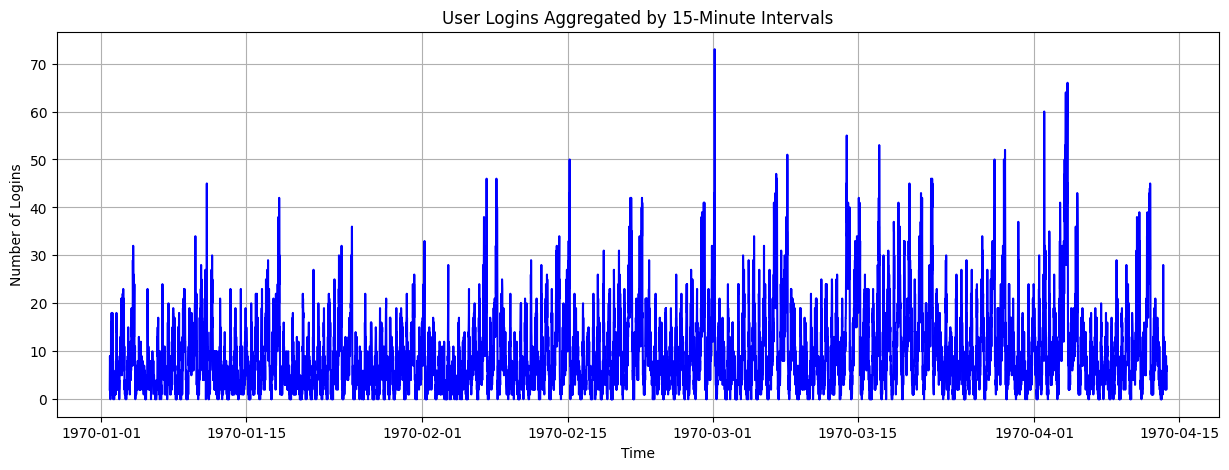

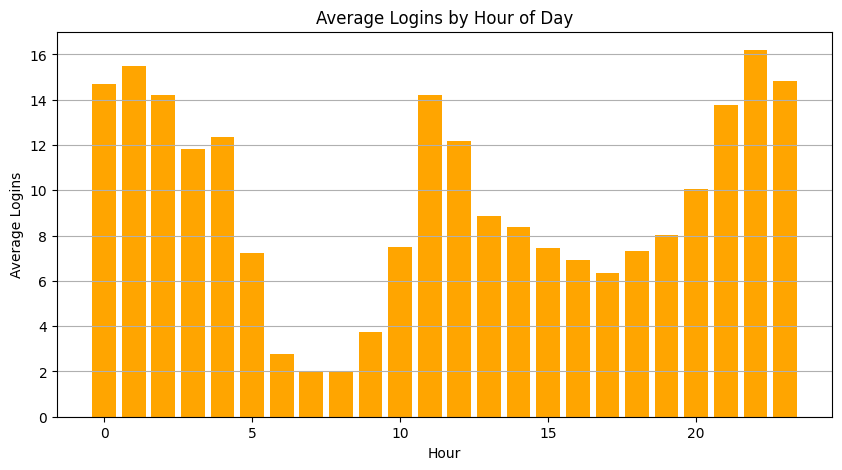

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

              precision    recall  f1-score   support

        True       1.00      1.00      1.00     10000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC: nan
[[10000]]


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# Part 2 Experiment and Metrics Design
The main measure of success would be the percentage of drivers who work in both Gotham and Metropolis, because this shows if the toll reimbursement is helping drivers serve both cities. 
To test this, I would randomly give some drivers the toll reimbursement (treatment group) and leave others without it (control group). 
Then I would track how many drivers from each group work in both cities over a few weeks. 
I would compare the two groups using a simple statistical test, like a two-proportion z-test, to see if the treatment group has more dual city drivers.
If the treatment group does better, the reimbursement works and could be applied to all drivers. One caution is that demand or other factors could affect results, so the experiment should run long enough to account for that.